In [1]:
# Imports
%matplotlib inline
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
def myshow(img):
    plt.imshow(sitk.GetArrayFromImage(img),cmap='Greys')

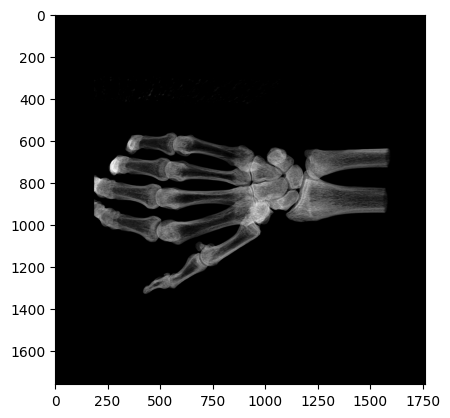

In [2]:
# Read in the white radiograph
whiteRadiograph = sitk.ReadImage("./Data/taskID_01_cam01.tif")
whiteRadiograph = sitk.ReadImage("./Data/wrist_vol_test_render.tif")
myshow(whiteRadiograph)

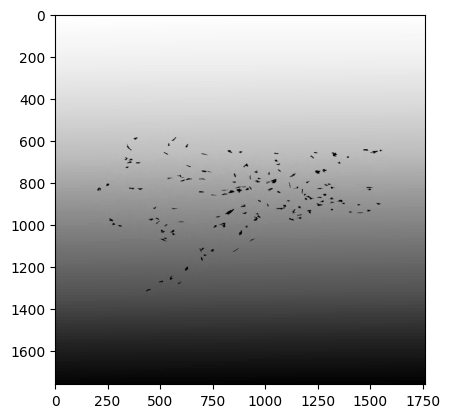

In [3]:
# Superpixel Segmentation
slicImageFilter = sitk.SLICImageFilter()
slicImageFilter.SetSuperGridSize([30,30,30]) # smaller grid size = finer grid overall default is [50,50,50]
slicImageFilter.SetSuperGridSize([15,15,15])
labelImage = slicImageFilter.Execute(whiteRadiograph)
myshow(labelImage)

In [4]:
# # Convert the label image to a label map
# labelMap = sitk.LabelImageToLabelMap(labelImage)
# # Make an overlay of the labelMap and white radiograph to more easily visualize the results
# overlay = sitk.LabelMapContourOverlay(labelMap, whiteRadiograph) # SUPER slow
# myshow(overlay)

In [5]:
# Get the mean pixel value for each label
labelStatsFilter = sitk.LabelStatisticsImageFilter()
labelStatsFilter.Execute(whiteRadiograph,labelImage)
N = labelStatsFilter.GetNumberOfLabels()
meanColor = np.zeros((N,1))
m,n = labelImage.GetSize()
labels = list(labelStatsFilter.GetLabels())
labels.sort()
for i, label in enumerate(labels):
    meanColor[i,0] = labelStatsFilter.GetMean(label)

In [6]:
# Create a binary label from the labelImage where all '1' are labels whose meanColor are < 255/3
labelShapeFilter = sitk.LabelShapeStatisticsImageFilter()
labelShapeFilter.Execute(labelImage)
binaryLabels = np.zeros((m,n))
for i, label in enumerate(labels):
    if label == 0:
        continue
    if meanColor[i,0] < 170: #255/3:
        pixels = list(labelShapeFilter.GetIndexes(label))
        for j in range(0,len(pixels),2):
            y = pixels[j]
            x = pixels[j+1]
            binaryLabels[x,y] = 1
# plt.imshow(binaryLabels)

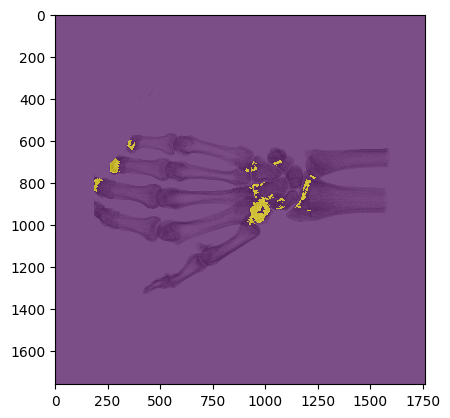

In [7]:
# Create an overlay with the binary label map
wrg = sitk.GetArrayFromImage(whiteRadiograph)
plt.figure()
plt.imshow(wrg, 'gray', interpolation='none')
plt.imshow(binaryLabels,interpolation='none', alpha=0.7)
plt.show()

In [8]:
# Calculate the Data Intensity Density
# Based off of https://discourse.itk.org/t/simpleitk-extract-largest-connected-component-from-binary-image/4958/2
binaryImage = sitk.Cast(sitk.GetImageFromArray(binaryLabels), sitk.sitkUInt8)
componetImage = sitk.ConnectedComponent(binaryImage)
sortedComponetImage = sitk.RelabelComponent(componetImage, sortByObjectSize=True)
largest = sortedComponetImage == 1
sumOfBin = np.sum(binaryLabels)
maxOfBin = np.sum(sitk.GetArrayFromImage(largest))
print("Sum: ", sumOfBin)
print("Max: ", maxOfBin)

Sum:  18522.0
Max:  8066
